## Descargar datos históricos de Bitcoin

Para comenzar el análisis, descargaremos el histórico de precios de **Bitcoin (BTC/USD)** desde Yahoo Finance.  
El dataset incluirá precios de apertura, cierre, máximo, mínimo y volumen, con frecuencia **diaria (1d)**.  

Usaremos la librería `yfinance`, muy útil para obtener datos financieros de forma sencilla.


In [12]:
import yfinance as yf

# Descargar datos históricos de BTC en USD
btc = yf.download("BTC-USD", start="2014-12-01", end="2020-12-31", interval="1d")

# Aplanar columnas si tienen varios niveles
btc.columns = btc.columns.to_flat_index()
btc.columns = [col if isinstance(col, str) else col[0] for col in btc.columns]

# Verificar columnas
print(btc.columns)

# Guardar en CSV
btc.to_csv("full_btc.csv", index=True)


C:\Users\dario.tomatis\AppData\Local\Temp\ipykernel_23416\2317336232.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2014-12-01", end="2020-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


## Enriquecer dataset con indicadores técnicos y variable objetivo

En esta sección se procesan los datos descargados de Bitcoin para agregar **indicadores técnicos** y la variable objetivo `y_true`.

### Pasos principales:
1. **Carga y ordenación del dataset**:  
   Se lee el archivo `full_btc.csv` y se asegura el orden cronológico de las fechas.

2. **Preparación de OHLCV**:  
   Se renombran las columnas (`Open`, `High`, `Low`, `Close`, `Volume`) a mayúsculas, ya que la librería `finta` requiere este formato.

3. **Cálculo de indicadores técnicos** con `finta`:  
   - **RSI (Relative Strength Index, 14 días)**  
   - **MACD y señal (12, 26, 9)**  
   - **SMA20 y EMA20 (medias móviles de 20 días)**  
   - **Bandas de Bollinger (superior e inferior)**  
   - **ATR (Average True Range, 14 días)**  
   - **CCI (Commodity Channel Index, 20 días)**  

4. **Columnas de probabilidad vacías**:  
   Se crean columnas para probabilidades calibradas de los modelos (`RFC`, `SGD`, `XGBoost`) y análisis de sentimiento (negativo, neutro, positivo), que se llenarán en etapas posteriores.

5. **Variable objetivo `y_true`**:  
   Se define como `1` si el **cierre del día siguiente** es mayor al del día actual, y `0` en caso contrario.  
   La última fila queda como `NA` porque no existe un día siguiente.

6. **Filtrado temporal**:  
   Se eliminan registros anteriores al **1 de enero de 2015** para mantener un histórico limpio.

7. **Guardado del dataset final**:  
   Se exporta nuevamente a `full_btc.csv` con todas las columnas listas para el análisis y modelado.


In [13]:
"""Lee el csv que guardaste en el paso anterior y lo procesa"""

# Requisitos:
# pip install pandas finta

import pandas as pd
from finta import TA

# 1) Cargar y ordenar
df = pd.read_csv("full_btc.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 2) Preparar OHLCV para finta (usa mayúsculas)
ohlcv = df.rename(
    columns={
        "Open": "OPEN",
        "High": "HIGH",
        "Low": "LOW",
        "Close": "CLOSE",
        "Volume": "VOLUME",
    }
)

# 3) Indicadores
df["RSI"] = TA.RSI(ohlcv, period=14)

macd = TA.MACD(ohlcv)  # columnas esperadas: MACD, SIGNAL, HISTOGRAM/hist
df["MACD"] = macd["MACD"]
df["MACD_SIGNAL"] = macd["SIGNAL"]

df["SMA20"] = TA.SMA(ohlcv, period=20)
df["EMA20"] = TA.EMA(ohlcv, period=20)

bb = TA.BBANDS(ohlcv, period=20)  # suele devolver: BB_UPPER, BB_MIDDLE, BB_LOWER
# Asegurar nombres esperados:
upper_col = [c for c in bb.columns if "UPPER" in c.upper()][0]
lower_col = [c for c in bb.columns if "LOWER" in c.upper()][0]
df["BB_UPPER"] = bb[upper_col]
df["BB_LOWER"] = bb[lower_col]

df["ATR"] = TA.ATR(ohlcv, period=14)
df["CCI"] = TA.CCI(ohlcv, period=20)

# 4) Columnas vacías (por ahora)
for col in [
    "proba_rfc_cal",
    "proba_sgd_cal",
    "proba_xgb_cal",
    "proba_sentiment_neg",
    "proba_sentiment_neu",
    "proba_sentiment_pos",
]:
    df[col] = pd.NA

# 5) y_true: 1 si el cierre de mañana > cierre de hoy, 0 en caso contrario
# (la última fila queda NA porque no existe "mañana" para compararla)
df["y_true"] = (df["Close"].shift(-1) > df["Close"]).astype("Int64")

# 6) Orden de columnas final
cols_final = [
    "Date", "Close", "High", "Low", "Open", "Volume",
    "RSI", "MACD", "MACD_SIGNAL", "SMA20", "EMA20",
    "BB_UPPER", "BB_LOWER", "ATR", "CCI",
    "proba_rfc_cal", "proba_sgd_cal", "proba_xgb_cal",
    "proba_sentiment_neg", "proba_sentiment_neu", "proba_sentiment_pos",
    "y_true",
]

# --- borrar anteriores a cierta fecha ---
fecha_limite = pd.to_datetime("2015-01-01")  
df = df[df["Date"] >= fecha_limite].reset_index(drop=True)


df[cols_final].to_csv("full_btc.csv", index=False)

print("Archivo generado: full_btc.csv")


Archivo generado: full_btc.csv


# Análisis Exploratorio Inicial del Dataset

En esta sección realizaremos un **Análisis Exploratorio de Datos (EDA)** sobre el dataset `full_btc.csv`.  
El objetivo es explorar la estructura de los datos, revisar valores nulos, detectar posibles outliers y visualizar las principales variables.

## 1. Cargar y revisar el dataset


In [14]:
import pandas as pd

# Cargar el dataset con la columna Date como tipo fecha
df = pd.read_csv("full_btc.csv", parse_dates=["Date"])

# Ver estructura del dataset
print("Dimensiones:", df.shape)
print("Primeras filas:")
display(df.head())

print("\nInformación general:")
df.info()


Dimensiones: (2191, 22)
Primeras filas:


,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_SIGNAL,SMA20,...,BB_LOWER,ATR,CCI,proba_rfc_cal,proba_sgd_cal,proba_xgb_cal,proba_sentiment_neg,proba_sentiment_neu,proba_sentiment_pos,y_true
0,2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,38.489292,-7.300009,-7.307049,324.905199,...,300.796628,10.457785,-67.048366,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,39.082869,-7.103004,-7.266214,323.287999,...,301.278212,9.779929,-72.911255,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,26.942806,-9.395007,-7.692189,319.760500,...,294.503316,11.193285,-238.732241,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,23.099278,-12.343080,-8.622745,315.703000,...,282.827360,12.519359,-355.581670,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,29.675503,-13.734021,-9.645332,313.073599,...,275.893058,12.551786,-250.366620,NaN,NaN,NaN,NaN,NaN,NaN,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2191 non-null   datetime64[ns]
 1   Close                2191 non-null   float64       
 2   High                 2191 non-null   float64       
 3   Low                  2191 non-null   float64       
 4   Open                 2191 non-null   float64       
 5   Volume               2191 non-null   int64         
 6   RSI                  2191 non-null   float64       
 7   MACD                 2191 non-null   float64       
 8   MACD_SIGNAL          2191 non-null   float64       
 9   SMA20                2191 non-null   float64       
 10  EMA20                2191 non-null   float64       
 11  BB_UPPER             2191 non-null   float64       
 12  BB_LOWER             2191 non-null   float64       
 13  ATR        

## 2. Resumen estadístico de las variables numéricas


In [15]:
# Resumen estadístico
df.describe(include="all").T


,count,mean,min,25%,50%,75%,max,std
Date,2191,2017-12-31 00:00:00.000000256,2015-01-01 00:00:00,2016-07-01 12:00:00,2017-12-31 00:00:00,2019-07-01 12:00:00,2020-12-30 00:00:00,NaN
Close,2191.0,5144.893952,178.102997,582.556,4122.939941,8659.020508,28840.953125,4814.814702
High,2191.0,5262.898256,211.731003,588.960999,4214.629883,8818.123535,28937.740234,4932.718554
Low,2191.0,4999.533108,171.509995,575.311981,4015.399902,8382.106445,27360.089844,4649.954918
Open,2191.0,5131.954641,176.897003,582.071014,4105.456055,8639.330566,27360.089844,4789.13234
Volume,2191.0,9709337547.90324,7860650.0,74438852.0,3783500000.0,16519661309.0,74156772075.0,13291499269.846102
RSI,2191.0,54.55216,9.920239,44.457772,53.513867,64.152511,94.302215,14.281047
MACD,2191.0,66.784969,-1474.432532,-24.451748,6.316832,127.434927,2561.862956,384.194924
MACD_SIGNAL,2191.0,63.376035,-1290.613349,-26.61534,6.267131,125.412628,2345.39415,357.537569
SMA20,2191.0,5038.108389,226.383199,582.242398,4024.616797,8597.794336,23174.762012,4605.117685


## 3. Revisión de valores nulos

Es importante verificar si existen valores faltantes en indicadores o variables calculadas, ya que podrían afectar los modelos.


In [16]:
# Conteo de valores nulos por columna
df.isnull().sum()


Date                      0
Close                     0
High                      0
Low                       0
Open                      0
Volume                    0
RSI                       0
MACD                      0
MACD_SIGNAL               0
SMA20                     0
EMA20                     0
BB_UPPER                  0
BB_LOWER                  0
ATR                       0
CCI                       0
proba_rfc_cal          2191
proba_sgd_cal          2191
proba_xgb_cal          2191
proba_sentiment_neg    2191
proba_sentiment_neu    2191
proba_sentiment_pos    2191
y_true                    0
dtype: int64

## 4. Distribución de precios y volumen

Visualizamos la evolución del **precio de cierre (close)** y el **volumen** para detectar patrones y anomalías.


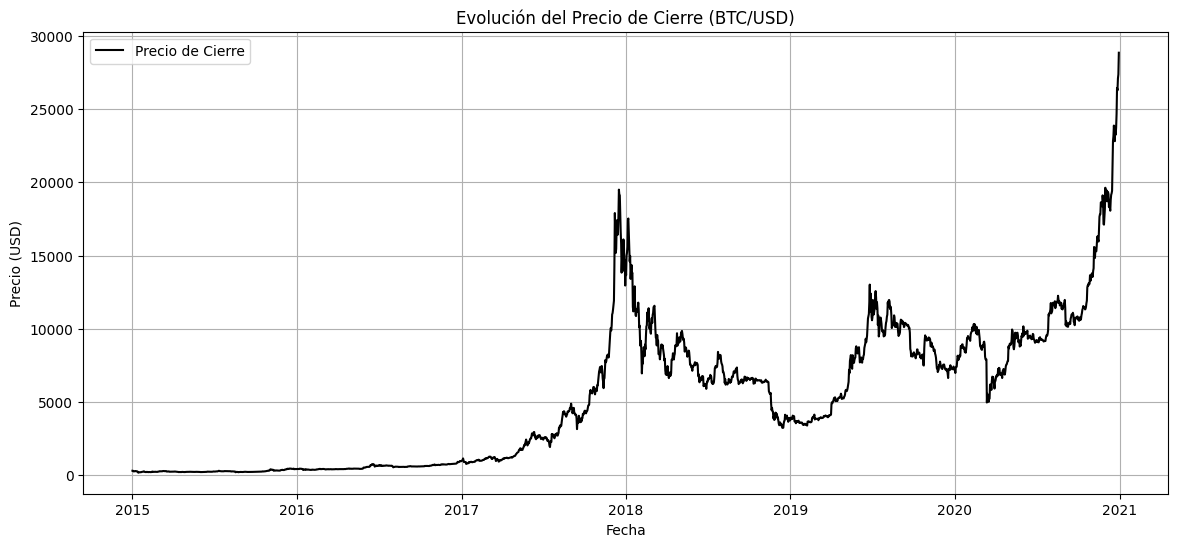

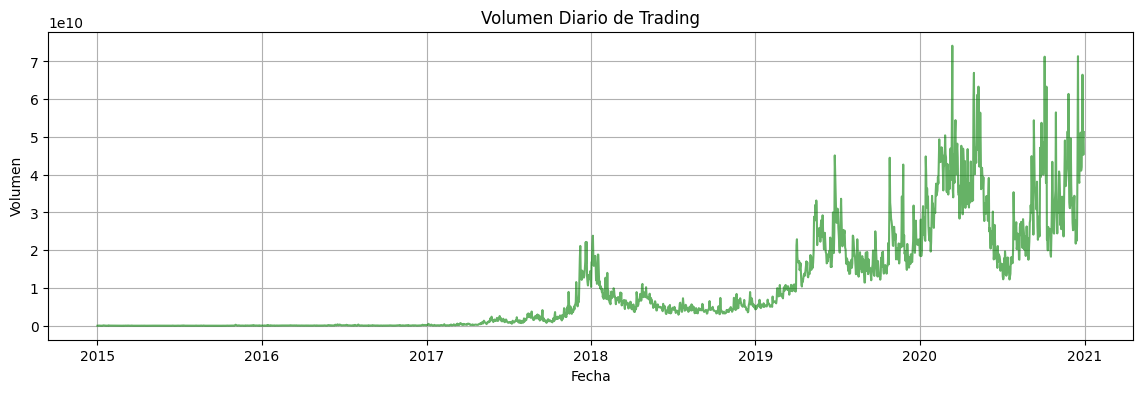

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Close"], label="Precio de Cierre", color="black")
plt.title("Evolución del Precio de Cierre (BTC/USD)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df["Date"], df["Volume"], color="green", alpha=0.6)
plt.title("Volumen Diario de Trading")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


## 5. Distribuciones y posibles outliers

Se utilizan **boxplots** para identificar outliers en variables clave: precio de cierre y volumen.


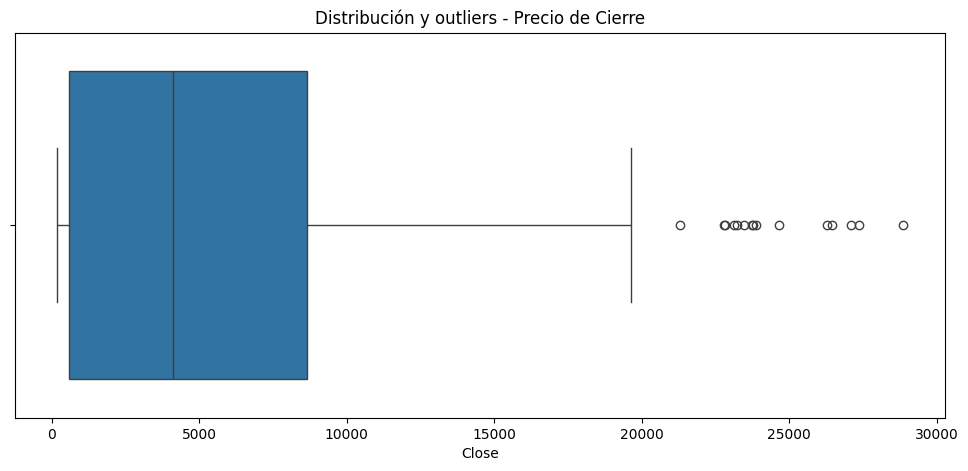

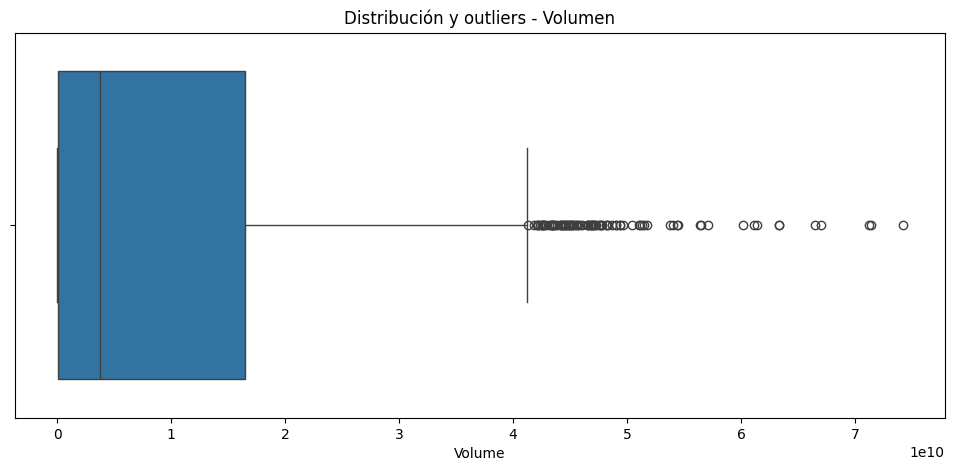

In [20]:
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(x=df["Close"])
plt.title("Distribución y outliers - Precio de Cierre")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=df["Volume"])
plt.title("Distribución y outliers - Volumen")
plt.show()


## 6. Correlaciones entre variables numéricas

Calculamos la **matriz de correlación** para observar relaciones entre indicadores técnicos y precio.


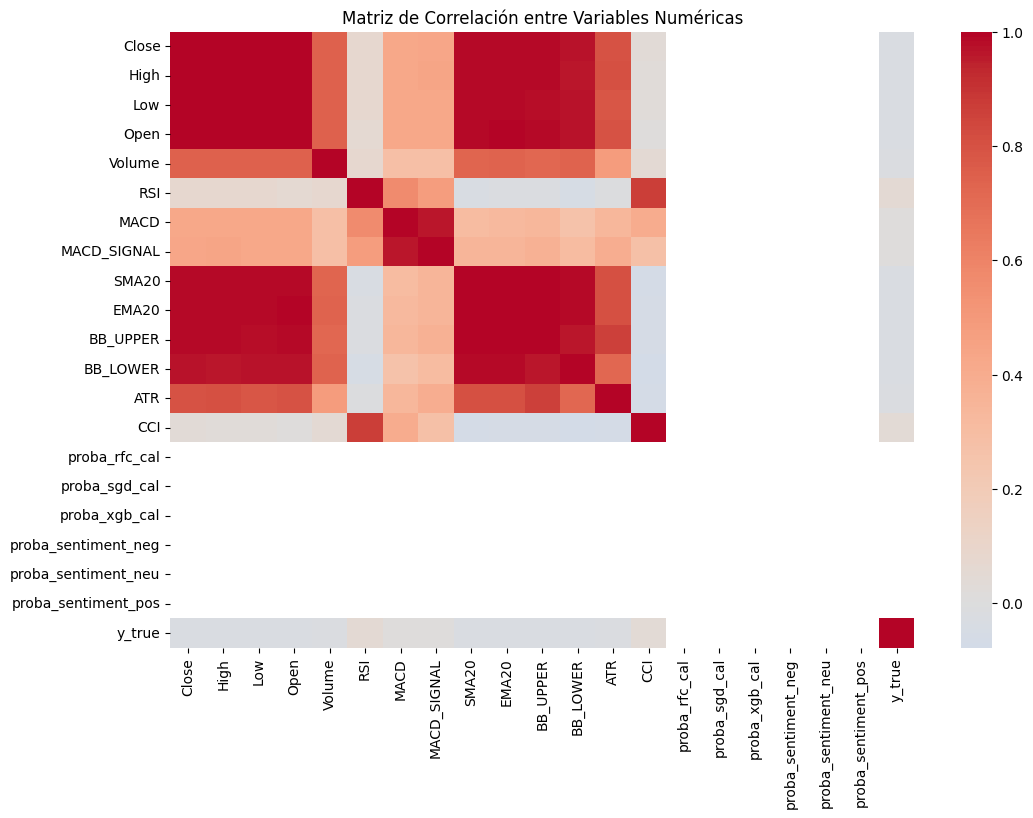

In [21]:
import numpy as np

corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()


## 7. Análisis de la variable objetivo `y_true`

La variable `y_true` indica:
- **1** si el precio de cierre del día siguiente fue mayor al del día actual.
- **0** en caso contrario.

Es importante revisar su balance para evaluar posibles problemas de clases desbalanceadas.


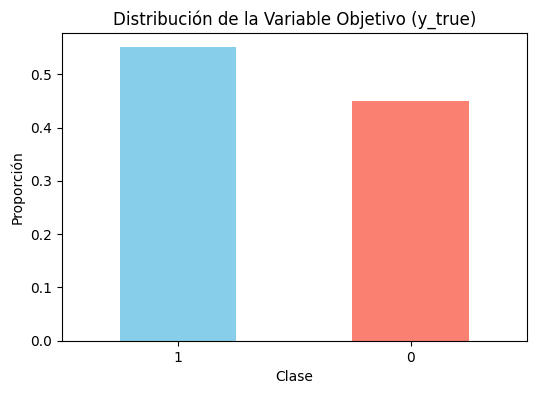

In [22]:
# Distribución de la variable objetivo
df["y_true"].value_counts(normalize=True).plot(
    kind="bar", figsize=(6,4), color=["skyblue","salmon"], rot=0
)
plt.title("Distribución de la Variable Objetivo (y_true)")
plt.xlabel("Clase")
plt.ylabel("Proporción")
plt.show()


# Conclusiones del Análisis Exploratorio Inicial

Tras explorar el dataset `full_btc.csv`, se obtienen los siguientes hallazgos:

## 1. Calidad de los datos
- El dataset contiene **2.191 registros diarios** entre 2015 y 2020.  
- Las columnas principales (`Date`, `Close`, `High`, `Low`, `Open`, `Volume`, indicadores técnicos y `y_true`) **no presentan valores nulos**.  
- Existen columnas reservadas para probabilidades (`proba_rfc_cal`, `proba_sgd_cal`, `proba_xgb_cal`, `proba_sentiment_neg`, `proba_sentiment_neu`, `proba_sentiment_pos`) que están **completamente vacías**, como era esperado en esta etapa previa al modelado.

## 2. Evolución del precio y volumen
- El **precio de cierre (Close)** muestra la volatilidad característica de Bitcoin, con ciclos de fuertes subidas (2017 y 2020) seguidos de correcciones.  
- El **volumen de trading** presenta picos muy marcados, sobre todo a partir de 2017, lo que puede estar asociado a períodos de especulación intensa o movimientos institucionales.

## 3. Posibles outliers
- Se identifican **outliers en el precio de cierre y el volumen**.  
  - En precios, corresponden a máximos históricos durante bull markets.  
  - En volumen, existen días con transacciones extraordinariamente altas que podrían distorsionar algunos análisis estadísticos.
- Estos outliers no necesariamente son errores, sino reflejo de la naturaleza del mercado de criptomonedas.

## 4. Indicadores técnicos
- El **RSI** oscila entre 10 y 94, lo que confirma la presencia de períodos de sobrecompra y sobreventa.  
- Los valores de **MACD y su señal** muestran gran dispersión, con máximos muy altos, lo que indica ciclos largos de tendencia.  
- **SMA20 y EMA20** siguen de cerca la serie de precios, como es esperado.  
- **ATR** confirma una volatilidad creciente en los últimos años.  
- **CCI** presenta valores extremos, útiles para detectar puntos de entrada y salida.

## 5. Correlaciones
- Existe una alta correlación entre los precios (`Close`, `High`, `Low`, `Open`) y también entre medias móviles (`SMA20`, `EMA20`) y bandas de Bollinger (`BB_UPPER`, `BB_LOWER`).  
- El **volumen** muestra una correlación baja con el precio, lo que sugiere que no siempre mayores volúmenes implican mayores precios.  
- Los campos de probabilidades (modelos y sentimiento) no aportan información aún, ya que están vacíos.

## 6. Variable objetivo (`y_true`)
- La variable `y_true` está **balanceada**:  
  - ~55% de casos con `1` (el precio subió al día siguiente).  
  - ~45% de casos con `0` (el precio bajó al día siguiente).  
- Este balance es adecuado para el entrenamiento de modelos de clasificación sin necesidad de aplicar técnicas fuertes de balanceo de clases.

---

### **Resumen**
- El dataset es **consistente y de buena calidad**, sin nulos en las variables principales.  
- Presenta **outliers reales** que reflejan la naturaleza volátil del mercado de Bitcoin.  
- La **variable objetivo está razonablemente balanceada**, lo cual es positivo para los modelos de Machine Learning.  
- Será necesario completar más adelante las columnas de probabilidades (`proba_*`) y de sentimiento para enriquecer el dataset antes del modelado.
